In [1]:
import popsims
import numpy as np
import matplotlib.pyplot as plt
import wisps
import pandas as pd
import wisps.simulations as wispsim
from tqdm import tqdm 
import astropy.units as u
import numba
%matplotlib inline

/users/caganze/research/splat


Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
thin_points=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf110.pkl')
names=[x.name for x in thin_points]
volumes=pd.read_pickle(wisps.OUTPUT_FILES+'/thick_disk_volumes.pkl')
DATA=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut_thick_disk.h5',\
     key=str('baraffe2003')+'F110_corrected')
THIN_DATA=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut_binaries_updatedrelations.h5',
                       key=str('baraffe2003')+str(350)+str('spt_abs_mag'))
DISTS=pd.read_pickle(wisps.OUTPUT_FILES+'/thick_disk_distances.pkl')

In [3]:
tot_volumes=abs(np.nansum([[volumes[s][k] for k in  names] for s in wispsim.SPGRID], axis=1))

In [4]:
AREA=4.1*(u.arcmin**2).to(u.radian**2)

In [23]:
hidx=200
thin_volumes=np.nansum([[x.volumes[hidx][s] for x in thin_points] \
                            for s in wispsim.SPGRID], axis=1)

In [36]:
np.nanmedian([x.dist_limits[17][0] for x in thin_points])

1166.599342265156

In [35]:
np.log10(thin_volumes[0]*AREA)

3.7084371874632507

[None, Text(0, 0.5, 'volume (kpc$^3$)')]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


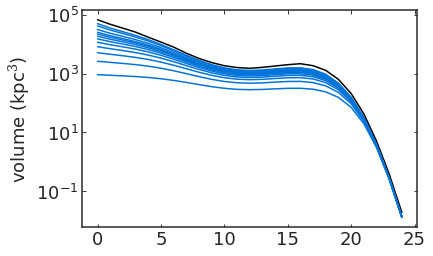

In [5]:
fig, ax=plt.subplots()
plt.plot(tot_volumes*AREA, color='k')
for hidx in thin_points[0].volumes.keys():
    thin_volumes=np.nansum([[x.volumes[hidx][s] for x in thin_points] \
                            for s in wispsim.SPGRID], axis=1)
    plt.plot(thin_volumes*AREA, color='#0074D9')
ax.set(yscale='log', ylabel=r'volume (kpc$^3$)')

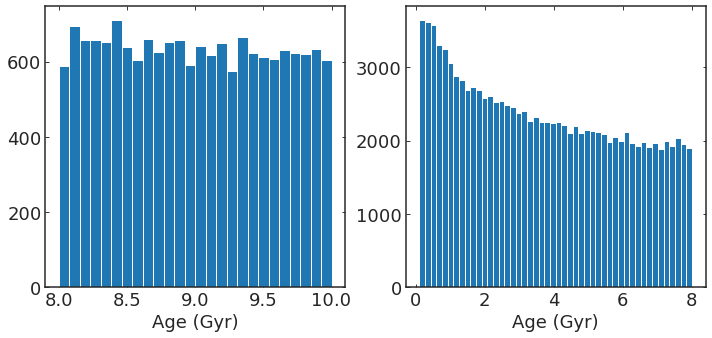

In [6]:
fig, ax=plt.subplots(ncols=2, figsize=(10, 4.5))
h_= ax[0].hist(DATA.age.values,  bins='auto')
h_= ax[1].hist( THIN_DATA.age.values[~THIN_DATA.is_cut],  bins='auto')
plt.tight_layout()
for a in ax:
    a.set(xlabel='Age (Gyr)')


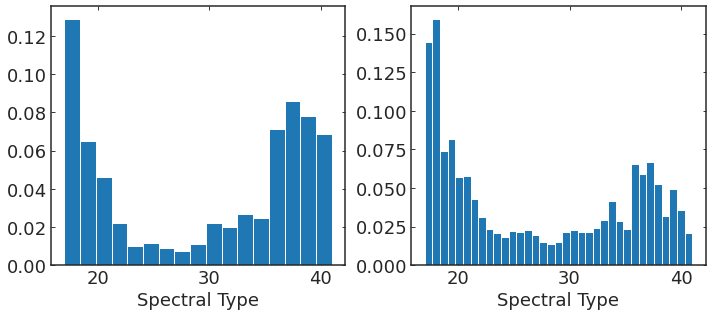

In [7]:
fig, ax=plt.subplots(ncols=2, figsize=(10, 4.5))
h_= ax[0].hist(DATA.spt.values,  bins='auto', density=True)
h_= ax[1].hist( THIN_DATA.spt.values[~THIN_DATA.is_cut],  bins='auto', density=True)
plt.tight_layout()
for a in ax:
    a.set(xlabel='Spectral Type')

plt.tight_layout()

In [8]:
 #THIN_DATA.columns

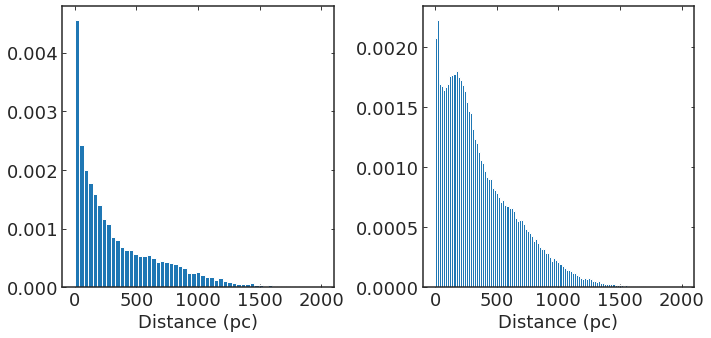

In [9]:
fig, ax=plt.subplots(ncols=2, figsize=(10, 4.5))
h_= ax[0].hist(DATA.dist.values,  bins='auto', density=True, range=[0,2000])
h_= ax[1].hist( THIN_DATA.dist.values[~THIN_DATA.is_cut],  bins='auto', density=True, \
               range=[0, 2000])
plt.tight_layout()

for a in ax:
    a.set(xlabel='Distance (pc)')


In [10]:
def get_simulated_number_model(df):
    cutdf=df.rename(columns={'temperature': 'teff', \
                                          'slprob': 'sl'})

    scale=[cutdf.scale.mean(), cutdf.scale_unc.mean(), cutdf.scale_times_model.mean()]
    
    NSIM=dict(zip(wispsim.SPGRID,np.zeros((len(wispsim.SPGRID), 2))))
    cutdf['spt_r']=cutdf.spt.apply(np.round)
    for g in cutdf.groupby('spt_r'):
        sn= len(cutdf.teff[np.logical_and(cutdf.teff>=450, cutdf.teff<=2100)])
        n0=scale[-1]/scale[0]
        #print (n0)
        scln=np.array([scale[0]*n0/sn,\
                       (scale[1]*scale[-1])/(sn*scale[0])])
        #scln=np.array(scale)
        #assert scln[0] > scale[0]
        NSIM[g[0]]=np.nansum(g[1].sl)*scln
    del cutdf
    return NSIM

def bin_by_spt_bin(sp_types, number, ltonly=False):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    if ltonly:
        ranges=[[17, 20], [20, 30], [30, 41]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

In [11]:
nexpct_dict=get_simulated_number_model(DATA)
tot_volumes_dict=dict(zip( wispsim.SPGRID, tot_volumes ))

In [12]:
nbers=np.array([nexpct_dict[k][0]*tot_volumes_dict[k]*AREA for k in wispsim.SPGRID])

In [13]:
dict(zip( wispsim.SPGRID, nbers))

{17: 90.98420310770005,
 18: 155.9838616532071,
 19: 58.56067327765991,
 20: 30.21928829698454,
 21: 17.972999631119052,
 22: 5.846112223864999,
 23: 2.158974855212088,
 24: 1.3429474163920818,
 25: 0.8371103804274932,
 26: 0.5108238806681044,
 27: 0.384138737226109,
 28: 0.27819965388976803,
 29: 0.40261766266108606,
 30: 0.8768654239472329,
 31: 0.8396716665546358,
 32: 1.0497910339552203,
 33: 1.2894848477213023,
 34: 1.5065470006611226,
 35: 0.6323242464570275,
 36: 1.2160680656777665,
 37: 0.4675981826547463,
 38: 0.0727643297486127,
 39: 0.008905466392576347,
 40: 0.00015362153496228036,
 41: 0.0}

In [14]:
bin_by_spt_bin(wispsim.SPGRID, nbers)

[305.5287380385671,
 57.54032242357276,
 2.412890314872561,
 5.562359972839513,
 2.3976602909307294]

In [15]:
THIN_DATA.columns

Index(['mass', 'age', 'temperature', 'luminosity', 'is_binary', 'spt',
       'prim_spt', 'sec_spt', 'pri_mass', 'sec_mass', 'prim_luminosity',
       'sec_luminosity', 'scale', 'scale_unc', 'scale_times_model', 'dist',
       'pntname', 'pnt', 'exp_image', 'exp_grism', 'absF110', 'prim_absF110',
       'sec_absF110', 'appF110', 'appF110er', 'absF140', 'prim_absF140',
       'sec_absF140', 'appF140', 'appF140er', 'absF160', 'prim_absF160',
       'sec_absF160', 'appF160', 'appF160er', 'snrj110', 'snrj140', 'snrjs160',
       'snrj', 'slprob', 'is_cut'],
      dtype='object')

In [16]:
#len(tot_volumes), len(wispsim.SPGRID)

In [17]:
#np.nanstd(df.to_pandas().col65)

In [18]:
#np.nanmax(df.to_pandas().col65)

In [19]:
#np.nanmin(df.to_pandas().col65)

In [20]:
def avr_sharma(sigma,  direction='vertical', verbose=False):
    verboseprint = print if verbose else lambda *a, **k: None
    result=None
    sigma=np.array(sigma).flatten()
    
    beta_dict={'radial': [(0.251, 0.006), 0.1,  (39.4, 0.3)],
                'vertical':[(0.441, 0.007), 0.1, (21.1, 0.2)],
               
                }

    verboseprint("Assuming Sharma et al. 2021 Metal-Rich Fits and {} velocity ".format(direction))
                            
    #propagate uncertainties via monte-carlo
    beta, tau1, sigma10=beta_dict[direction]
   
    #case for floats
    if sigma.size==1:
        beta_norm= np.random.normal(*beta, 1000)
        sigma10_norm= np.random.normal(*sigma10, 1000)
        result=((sigma/ sigma10_norm)**(1/ beta_norm))*(10+tau1)-tau1
        return np.nanmedian(result), np.nanstd(result)
    
    #case for arrays
    if sigma.size >1:
        beta_norm= np.random.normal(*beta, (1000, len(sigma)))
        sigma10_norm= np.random.normal(*sigma10, (1000, len(sigma)))

        result=((sigma/ sigma10_norm)**(1/ beta_norm))*(10+tau1)-tau1
        return np.nanmedian(result, axis=0), np.nanstd(result, axis=0)

In [21]:
 avr_sharma([15, 16])

(array([4.55463075, 5.29668226]), array([0.11254171, 0.12827574]))

In [22]:
avr_sharma(0)

(-0.1, 1.3877787807814457e-17)